# PandaRoot Simulation Plots

Plots of the **MC points** in the tracking systems of the PANDA detector, created with PandaRoot.

## Python Imports

Import the required python packages

In [1]:
# python IO for ROOT files
import uproot

# OS to get acess to the bash environment variables
import os

# to render latex in prints
from IPython.display import display, Latex

# numpy
import numpy as np

# For interactive plotting
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import transforms
# %matplotlib widget

# Seaborn for plotting and styling
import seaborn as sns

# Pandas for data manipulation
import pandas as pd

# to get access to the pdg database 2024 version
import pdg
PdgApi = pdg.connect('sqlite:///../pdgall-2024-v0.1.0.sqlite')

## IO Paths

Get/set the paths to the input and output files.

Name of the simulations (prefix) that should be plotted:

In [2]:
projectName = "XiAntiXi"

Path where the images should be saved

In [3]:
imagePath = os.getenv("PANDAML_IMAGE_PATH") + "/sim/" + projectName
print("Images will be saved in", imagePath)

Images will be saved in /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi


Path to the simulation ROOT file

In [4]:
simFile = os.getenv("SIM_FILE_PATH")  + "/" + projectName + "/root/" + projectName + "_sim.root"
print("Input simulation file: ",simFile)
mcPoint_params = uproot.open(simFile+":pndsim")

Input simulation file:  /home/nikin105/mlProject/simFiles/XiAntiXi/root/XiAntiXi_sim.root


## Global Variables

In [5]:
particleNameDict = {
	"p"         : r"p",
	"pbar"      : r"\bar{p}",
	"pi+"       : r"\pi^+",
	"pi-"       : r"\pi^-",
	"e+"        : r"e^+",
	"e-"        : r"e^-",
	"Xibar+"    : r"\bar{\Xi}^+",
	"Xi-"       : r"\Xi^-",
	"Lambda0"   : r"\Lambda^0",
	"Lambdabar0": r"\bar{\Lambda}^0",
	"mu+"       : r"\mu^+",
	"mu-"       : r"\mu^-",
}

## Helper Functions

In [6]:
def makeTrackDict(trackIDs, trackParameter, trackDict):
	""" This function creates a dictionary with the trackID as the key and arrays with track parameters (coordinates, momenta, etc.)
	    corresponding to the trackID as the values

	Args:
		trackIDs (array): List of track IDs
		trackParameter (array): List of track parameters
		trackDict (dictionary): Dictionary with trackID as the key and arrays with track parameters as the values

	Returns:
		dictionary: Dictionary with trackID as the key and arrays with track parameters as the values
	"""
	point = 0
 	# Iterate over all track IDs
	for trackID in trackIDs:
		if trackID not in trackDict:
			trackDict[trackID]  = np.zeros(0)
		trackDict[trackID]  = np.append(trackDict[trackID], trackParameter[point])
		point += 1
	return trackDict

In [7]:
def create_rotated_cross(x, y, angle, ax, size=0.2, color='blue',lw=2):
	"""Function to create a rotated cross at position (x, y).

	Args:
		x (float): x coordinate of the cross
		y (float): y coordinate of the cross
		angle (float): angle of the cross in degrees
		ax (axis): axis of a given matplotlib figure
		size (float, optional): size of the cross. Defaults to 0.2.
		color (str, optional): color of the cross. Defaults to 'blue'.
		lw (int, optional): line width of the cross. Defaults to 2.
	"""
	# Prepare the cross transformation (rotation and translation)
	transform = transforms.Affine2D().rotate_deg(angle) + transforms.Affine2D().translate(x, y) + ax.transData
	# Create a cross as a combination of two rectangles (or lines)
	cross = patches.PathPatch(
		patches.Path([
			(-size, 0), (size, 0),
			(0, 0), (0, size),
			(0, -size) 
		]),
		fill=False, fc="None", ec=color, transform=transform, lw=lw)
	# Add the cross to the axes
	ax.add_patch(cross)

In [8]:
def getParticleTexName(pdgID):
	"""Get the latex formatted name of a particle from its PDG ID

	Args:
		pdgID (int, string): PDG ID

	Returns:
		string: Latex formatted name of the particle
	"""
	return particleNameDict[PdgApi.get_particle_by_mcid(str(pdgID)).name]

In [9]:
def getProcess(trackID, pdgID, motherID, secondMotherID, maxReactionDepth = np.inf):
	"""Get the the reaction chain leading to the particle with the given trackID with a given maximum reaction depth

	Args:
		trackID (int): ID of the particle track
		pdgID (array): List with the PDG IDs of the particles
		motherID (array): List with the mother particle IDs (mother particles of the secondary particles)
		secondMotherID (array): List with the second mother particle IDs (mother particles of the primary particles)
		maxReactionDepth (int, optional): maximal number of contribution particles. Defaults to np.inf.

	Returns:
		string: Latex formatted string of the reaction chain
	"""
	currMID      = trackID
	curr2ndMID   = trackID
	reactionStep = 0
	
	# Name of the final particle
	reactionName = fr"$ {getParticleTexName(pdgID[trackID])}_{{{trackID}}} $ "
	
	# Iterate over the mother particles of the secondary particles until a primary particle or the maximum reaction depth is reached 
	while currMID != -1 and reactionStep < maxReactionDepth:
		# Ensure that the first particle is not included twice
		if reactionStep != 0:
			reactionName = fr"$ {getParticleTexName(pdgID[currMID])}_{{{currMID}}} \to $ " + reactionName
  		# When the last secondary particle is reached set the primary particle ID
		if motherID[currMID] == -1:
			curr2ndMID = currMID
		currMID = motherID[currMID]
		reactionStep += 1
	
	# Iterate over the mother particles of the primary particles until the first primary particle or the maximum reaction depth is reached
	while curr2ndMID != -1 and reactionStep < maxReactionDepth:
		curr2ndMID = secondMotherID[curr2ndMID]
		# Check if the current particle is ppbar (88888) and set the reaction name accordingly as it is not in the pdg database
		if pdgID[curr2ndMID] == 88888 and reactionStep != 0:
			reactionName = r"$ p\bar{p}\to $ " + reactionName
		elif curr2ndMID != -1 and reactionStep != 0:
			reactionName = fr"$ {getParticleTexName(pdgID[curr2ndMID])}_{{{curr2ndMID}}} \to $ " + reactionName
		reactionStep += 1
	
	return reactionName

## Simulation Parameters

### Description: MC Track Parameters - `MCTrack`

| Parameter Name	| Description 											| Unit	| Type			|	 Class							|
|-------------------|-------------------------------------------------------|-------|---------------|-----------------------------------|
| UniqueID			| Object unique identifier								| -		| UInt_t		| TObject							|
| Bits				| Bit field status word									| -		| UInt_t		| TObject 							|
| PdgCode			|														|		| Int_t			| PndMCTrack						|
| P(x,y,z)			|														|		| Double32_t	| PndMCTrack						|
| E					|														|		| Double32_t	| PndMCTrack						|
| MotherID			|														|		| Int_t			| PndMCTrack						|
| SecondMotherID	|														|		| Int_t			| PndMCTrack						|
| GeneratorFlags	|														|		| Int_t			| PndMCTrack						|
| Start(X,Y,Z)		|														|		| Double32_t	| PndMCTrack						|
| StartT			|														|		| Double32_t	| PndMCTrack						|
| Points			|														|		| Int_t			| PndMCTrack						|
| Process			|														|		| UInt_t		| PndMCTrack						|

### Description: Straw Tube Detector (STT) Parameters - `STTPoint`

pos and mom are given in x, y, and z coordinates in the lab frame

| Parameter Name	| Description 											| Unit	| Type			|	 Class							|
|-------------------|-------------------------------------------------------|-------|---------------|-----------------------------------|
| UniqueID			| Object unique identifier								| -		| UInt_t		| TObject							|
| Bits				| Bit field status word									| -		| UInt_t		| TObject 							|
| Link				| 														| -		| unique_ptr	| FairMultiLinkedData_Interface		|
| TrackID			| Track index											| -		| Int_t			| FairMCPoint						|
| EventId			| MC Event id											| -		| UInt_t		| FairMCPoint						|
| P(x,y,z)			| Momentum components									| GeV	| Double32_t	| FairMCPoint						|
| Time				| Time since event start								| ns	| Double32_t	| FairMCPoint						|
| Length			| Track length since creation							| cm	| Double32_t	| FairMCPoint						|
| ELoss				| Energy loss at this point								| GeV	| Double32_t	| FairMCPoint						|
| DetectorID		| Detector unique identifier 							| -		| Int_t			| FairMCPoint						|
| (X,Y,Z)			| Position of hit 										| cm	| Double32_t	| FairMCPoint						|
| (X,Y,Z)_out_local	| Exit coordinates in straw frame						|		| Double_t		| PndSttPoint						|
| (X,Y,Z)_in_local	| Entry coordinates in straw frame						|		| Double_t		| PndSttPoint						|
| P(x,y,z)_in		| *unused member*										|		| Double_t		| PndSttPoint						|
| P(x,y,z)_out		| 														|		| Double_t		| PndSttPoint						|
| Mass				| Particle mass											|		| Double_t		| PndSttPoint						|
| TubeID			| Tube ID												|		| Int_t			| PndSttPoint						|

### Description: Micro Vertex Detector (MVD) Parameters - `MVDPoint`

pos and mom are given in x, y, and z coordinates in the lab frame

| Parameter Name	| Description 											| Unit	| Type			|	 Class							|
|-------------------|-------------------------------------------------------|-------|---------------|-----------------------------------|
| UniqueID			| Object unique identifier								| -		| UInt_t		| TObject							|
| Bits				| Bit field status word									| -		| UInt_t		| TObject 							|
| Link				| 														| -		| unique_ptr	| FairMultiLinkedData_Interface		|
| TrackID			| Track index											| -		| Int_t			| FairMCPoint						|
| EventId			| MC Event id											| -		| UInt_t		| FairMCPoint						|
| P(x,y,z)			| Momentum components									| GeV	| Double32_t	| FairMCPoint						|
| Time				| Time since event start								| ns	| Double32_t	| FairMCPoint						|
| Length			| Track length since creation							| cm	| Double32_t	| FairMCPoint						|
| ELoss				| Energy loss at this point								| GeV	| Double32_t	| FairMCPoint						|
| DetectorID		| Detector unique identifier 							| -		| Int_t			| FairMCPoint						|
| (X,Y,Z)			| Position of hit 										| cm	| Double32_t	| FairMCPoint						|
| (X,Y,Z)Out		| 														|		| Double32_t	| PndMCPoint						|
| P(x,y,z)Out		| 														|		| Double32_t	| PndMCPoint						|
| SensorID			| 														|		| Int_t			| PndSdsMCPoint 					|

### Set the Parameters

In [10]:
eventNumber = 0

# Get STT geometry
data : pd.DataFrame = pd.read_csv('/home/nikin105/mlProject/pandaml/visualization/detectorGeometries/STT/tubePos.csv')
data.columns = data.columns.str.strip()

# Get MC Track parameters
mcTrack_pdgId = mcPoint_params["MCTrack.fPdgCode"].array(library="np")[eventNumber]
mcTrack_motherId = mcPoint_params["MCTrack.fMotherID"].array(library="np")[eventNumber]
mcTrack_2ndMotherId = mcPoint_params["MCTrack.fSecondMotherID"].array(library="np")[eventNumber]
mcTrack_vertex_x = mcPoint_params["MCTrack.fStartX"].array(library="np")[eventNumber]
mcTrack_vertex_y = mcPoint_params["MCTrack.fStartY"].array(library="np")[eventNumber]
mcTrack_vertex_z = mcPoint_params["MCTrack.fStartZ"].array(library="np")[eventNumber]
mcTrack_genFlags = mcPoint_params["MCTrack.fGeneratorFlags"].array(library="np")[eventNumber]

# Get STT parameters

# Coordinates
stt_x = mcPoint_params["STTPoint.fX"].array(library="np")[eventNumber]
stt_y = mcPoint_params["STTPoint.fY"].array(library="np")[eventNumber]
stt_z = mcPoint_params["STTPoint.fZ"].array(library="np")[eventNumber]

# Momenta
stt_px = mcPoint_params["STTPoint.fPx"].array(library="np")[eventNumber]
stt_py = mcPoint_params["STTPoint.fPy"].array(library="np")[eventNumber]
stt_pz = mcPoint_params["STTPoint.fPz"].array(library="np")[eventNumber]

# Time
stt_t = mcPoint_params["STTPoint.fTime"].array(library="np")[eventNumber]

# Energy loss
stt_dE = mcPoint_params["STTPoint/STTPoint.fELoss"].array(library="np")[eventNumber]

# Tube ID
stt_tubeID = mcPoint_params["STTPoint.fTubeID"].array(library="np")[eventNumber]

# Track ID
stt_trackIDs = mcPoint_params["STTPoint.fTrackID"].array(library="np")[eventNumber]

# Get MVD parameters

# Coordinates
mvd_x = mcPoint_params["MVDPoint.fX"].array(library="np")[eventNumber]
mvd_y = mcPoint_params["MVDPoint.fY"].array(library="np")[eventNumber]
mvd_z = mcPoint_params["MVDPoint.fZ"].array(library="np")[eventNumber]

# Momenta
mvd_px = mcPoint_params["MVDPoint.fPx"].array(library="np")[eventNumber]
mvd_py = mcPoint_params["MVDPoint.fPy"].array(library="np")[eventNumber]
mvd_pz = mcPoint_params["MVDPoint.fPz"].array(library="np")[eventNumber]

# Time
mvd_t = mcPoint_params["MVDPoint.fTime"].array(library="np")[eventNumber]

# Energy loss
mvd_dE = mcPoint_params["MVDPoint/MVDPoint.fELoss"].array(library="np")[eventNumber]

# Track ID
mvd_trackIDs = mcPoint_params["MVDPoint.fTrackID"].array(library="np")[eventNumber]

# Normalize the xy-projections of the momenta
stt_totMom = np.sqrt(stt_px**2 + stt_py**2)
mvd_totMom = np.sqrt(mvd_px**2 + mvd_py**2)

stt_normPx = stt_px/stt_totMom
stt_normPy = stt_py/stt_totMom

mvd_normPx = mvd_px/mvd_totMom
mvd_normPy = mvd_py/mvd_totMom

# get the absolute momenta
stt_p = np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)
mvd_p = np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)

# Define dictionaries with the trackID as the key and arrays with x, y & z coordinates and momenta as the values
xPointsPerTrack = {}
xPointsPerTrack = makeTrackDict(stt_trackIDs, stt_x, xPointsPerTrack)
# xPointsPerTrack = makeTrackDict(mvd_trackIDs, mvd_x, xPointsPerTrack)

yPointsPerTrack = {}
yPointsPerTrack = makeTrackDict(stt_trackIDs, stt_y, yPointsPerTrack)
# yPointsPerTrack = makeTrackDict(mvd_trackIDs, mvd_y, yPointsPerTrack)

zPointsPerTrack = {}
zPointsPerTrack = makeTrackDict(stt_trackIDs, stt_z, zPointsPerTrack)
# zPointsPerTrack = makeTrackDict(mvd_trackIDs, mvd_z, zPointsPerTrack)

xMomentaPerTrack = {}
xMomentaPerTrack = makeTrackDict(stt_trackIDs, stt_px, xMomentaPerTrack)
# xMomentaPerTrack = makeTrackDict(mvd_trackIDs, mvd_px, xMomentaPerTrack)

yMomentaPerTrack = {}
yMomentaPerTrack = makeTrackDict(stt_trackIDs, stt_py, yMomentaPerTrack)
# yMomentaPerTrack = makeTrackDict(mvd_trackIDs, mvd_py, yMomentaPerTrack)

zMomentaPerTrack = {}
zMomentaPerTrack = 	makeTrackDict(stt_trackIDs, stt_pz, zMomentaPerTrack)
# zMomentaPerTrack = 	makeTrackDict(mvd_trackIDs, mvd_pz, zMomentaPerTrack)

tubeIDPerTrack = {}
tubeIDPerTrack = makeTrackDict(stt_trackIDs, stt_tubeID, tubeIDPerTrack)

# Dictionary to store the information if a track is a primary track
isSttTrackPrimary = {}
for trackID in stt_trackIDs:
	isSttTrackPrimary[trackID] = mcTrack_motherId[trackID] == -1
 
# Get the number of primary tracks
nPrimaryTracks   = 0
nSecondaryTracks = 0
for track in isSttTrackPrimary:
	if isSttTrackPrimary[track]:
		nPrimaryTracks = nPrimaryTracks + 1
	else:
		nSecondaryTracks = nSecondaryTracks + 1

In [11]:
test = np.where(stt_trackIDs == 10)[0]
test_t = np.zeros(len(test))
test_x = np.zeros(len(test))
test_y = np.zeros(len(test))
j=0
for i in test:
	test_t[j] = stt_t[i]
	test_x[j] = stt_x[i]
	test_y[j] = stt_y[i]
	j+=1

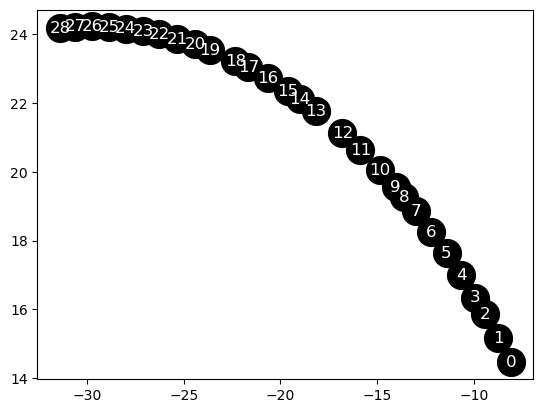

In [12]:
fig, ax = plt.subplots()
order = 0
colors = sns.color_palette("crest", len(test))

for i in test:
    ax.plot(stt_x[i], stt_y[i], marker='o', markersize=20, color="black")
    ax.text(test_x[order], test_y[order], str(order), ha='center', va='center', fontsize=12, color='white')
    order += 1

In [13]:
maxReactionDepth = 2

print("Primary Tracks:", nPrimaryTracks)
print("Secondary Tracks:", nSecondaryTracks)

for trackID in xPointsPerTrack:
	reactionName = getProcess(trackID, mcTrack_pdgId, mcTrack_motherId, mcTrack_2ndMotherId)
	if isSttTrackPrimary[trackID]:
		display("Primary Track", Latex(reactionName))
	else:
		display("Secondary Track", Latex(reactionName))

Primary Tracks: 6
Secondary Tracks: 1


'Primary Track'

<IPython.core.display.Latex object>

'Primary Track'

<IPython.core.display.Latex object>

'Primary Track'

<IPython.core.display.Latex object>

'Primary Track'

<IPython.core.display.Latex object>

'Primary Track'

<IPython.core.display.Latex object>

'Primary Track'

<IPython.core.display.Latex object>

'Secondary Track'

<IPython.core.display.Latex object>

## Plots

### xy-Projections with Colormaps for various Parameters


#### z-Position

Min z:  20.969999313354492  cm
Max z:  109.16710662841797  cm
Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionZ_0.png
Saving pdf image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionZ_0.pdf


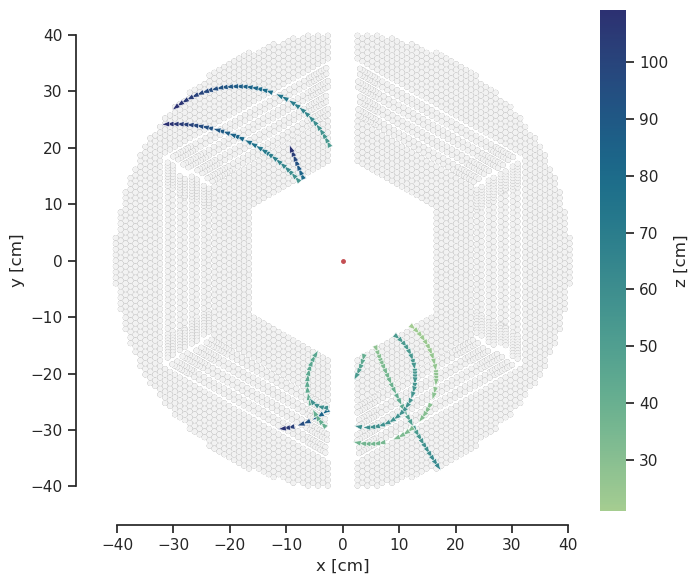

In [14]:

# find out what the maximum and minimum z values are
z_coords = np.concatenate((stt_z, mvd_z))
min_z = np.min(z_coords)
print("Min z: ", np.min(z_coords), " cm")
max_z = np.max(z_coords)
print("Max z: ", np.max(z_coords), " cm")

# Create a normalization object
zNorm = mcolors.Normalize(vmin=min_z, vmax=max_z)

plt.close('all')

# Set the general style of the plot using seaborn
sns.set_theme(color_codes=True)
sns.set_style("ticks")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(8,6))

# Plot the IP
ax.plot(0,0,marker='.',ms=5, color='r')

# Plot the STT in the background
for index, row in data.iterrows():
        sttOuterTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['outerRadius[cm]'], fc='gray', ec="None")
        ax.add_patch(sttOuterTube)
        sttInnerTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['innerRadius[cm]'], fc='white', ec="None", alpha=0.9)
        ax.add_patch(sttInnerTube)

# plot the STT MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the z coordinate
sttQuiver = ax.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_z, pivot='mid', cmap='crest', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=zNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

sns.despine(fig=fig, ax=ax, offset=10, trim=True)

# # Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add and format the color bar 
cbar = fig.colorbar(sttQuiver, cax=cax, orientation='vertical', label='z [cm]')
cbar.outline.set_visible(False)

# Set the axis labels and limits
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

fig.tight_layout()	

imgPath = imagePath + "/xyProjectionZ_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Time

Min t:  1.0499770641326904  ns
Max t:  25.600261688232422  ns
Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionTime_0.png
Saving pdf image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionTime_0.pdf


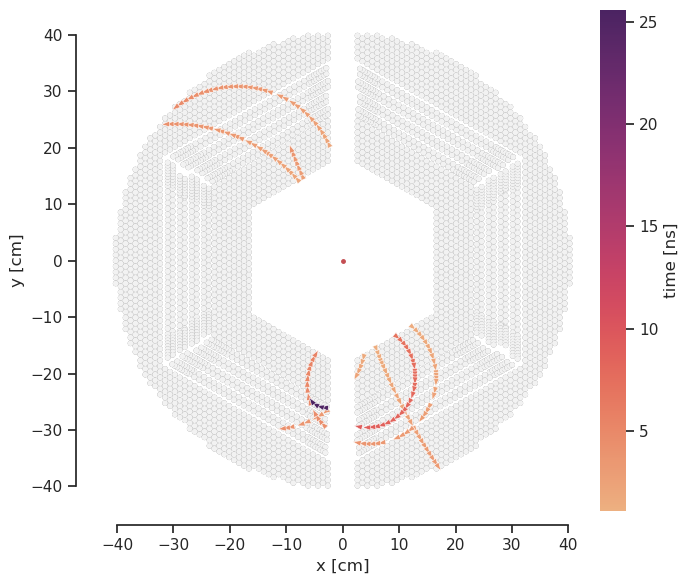

In [15]:
# find out what the maximum and minimum t values are
times = np.concatenate((stt_t, mvd_t))
min_t = np.min(times)
print("Min t: ", min_t, " ns")
max_t = np.max(times)
print("Max t: ", max_t, " ns")

# Create a normalization object
tNorm = mcolors.Normalize(vmin=min_t, vmax=max_t)

plt.close('all')

# Set the general style of the plot using seaborn
sns.set_theme(color_codes=True)
sns.set_style("ticks")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(8,6))

# Plot the IP
ax.plot(0,0,marker='.',ms=5, color='r')

# Plot the STT in the background
for index, row in data.iterrows():
        sttOuterTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['outerRadius[cm]'], fc='gray', ec="None")
        ax.add_patch(sttOuterTube)
        sttInnerTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['innerRadius[cm]'], fc='white', ec="None", alpha=0.9)
        ax.add_patch(sttInnerTube)

# plot the STT MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the time
sttQuiver = ax.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_t, pivot='mid', cmap='flare', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

sns.despine(fig=fig, ax=ax, offset=10, trim=True)

# # Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add and format the color bar 
cbar = fig.colorbar(sttQuiver, cax=cax, orientation='vertical', label='time [ns]')
cbar.outline.set_visible(False)

# Set the axis labels and limits
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

fig.tight_layout()	

imgPath = imagePath + "/xyProjectionTime_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Momentum

Min p:  0.01568048998542473  GeV
Max p:  2.7742482467353504  GeV
Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionMomentum_0.png
Saving pdf image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionMomentum_0.pdf


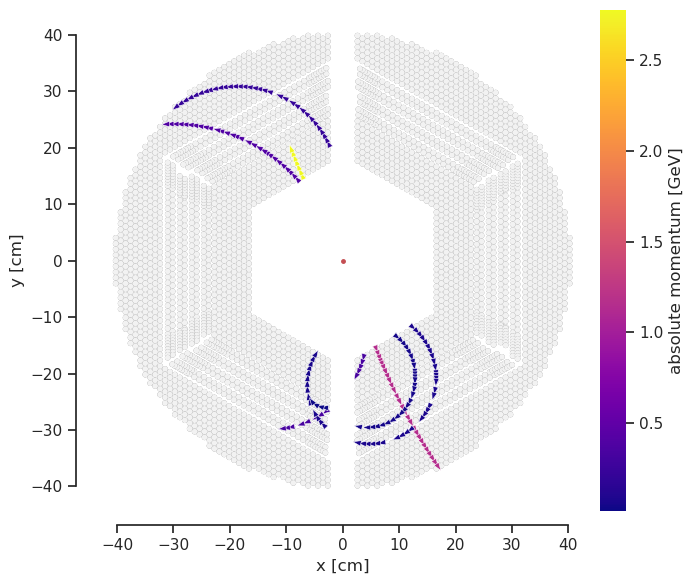

In [16]:
# find out what the maximum and minimum p values are
momenta = np.concatenate((stt_p, mvd_p))
min_p = np.min(momenta)
print("Min p: ", min_p, " GeV")
max_p = np.max(momenta)
print("Max p: ", max_p, " GeV")

# Create a normalization object
pNorm = mcolors.Normalize(vmin=min_p, vmax=max_p)

plt.close('all')

# Set the general style of the plot using seaborn
sns.set_theme(color_codes=True)
sns.set_style("ticks")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(8,6))

# Plot the IP
ax.plot(0,0,marker='.',ms=5, color='r')

# Plot the STT in the background
for index, row in data.iterrows():
        sttOuterTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['outerRadius[cm]'], fc='gray', ec="None")
        ax.add_patch(sttOuterTube)
        sttInnerTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['innerRadius[cm]'], fc='white', ec="None", alpha=0.9)
        ax.add_patch(sttInnerTube)

# plot the STT MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum magnitude
sttQuiver = ax.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_p, pivot='mid', cmap='plasma', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

sns.despine(fig=fig, ax=ax, offset=10, trim=True)

# # Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add and format the color bar 
cbar = fig.colorbar(sttQuiver, cax=cax, orientation='vertical', label='absolute momentum [GeV]')
cbar.outline.set_visible(False)

# Set the axis labels and limits
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

fig.tight_layout()	

imgPath = imagePath + "/xyProjectionMomentum_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Energy Loss

Min dE:  1.3985356872581178e-06  GeV
Max dE:  0.00014099999680183828  GeV
Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionEnergyLoss_0.png
Saving pdf image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionEnergyLoss_0.pdf


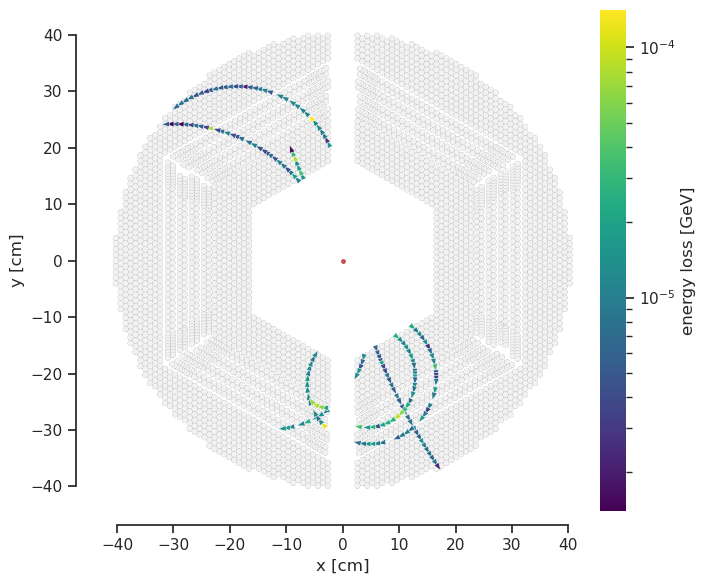

In [17]:
# find out what the maximum and minimum dE values are
energyLoss = np.concatenate((stt_dE, mvd_dE))
min_dE = np.min(energyLoss)
print("Min dE: ", min_dE, " GeV")
max_dE = np.max(energyLoss)
print("Max dE: ", max_dE, " GeV")

# Create a normalization object
dENorm = mcolors.LogNorm(vmin=min_dE, vmax=max_dE)

plt.close('all')

# Set the general style of the plot using seaborn
sns.set_theme(color_codes=True)
sns.set_style("ticks")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(8,6))

# Plot the IP
ax.plot(0,0,marker='.',ms=5, color='r')

# Plot the STT in the background
for index, row in data.iterrows():
        sttOuterTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['outerRadius[cm]'], fc='gray', ec="None")
        ax.add_patch(sttOuterTube)
        sttInnerTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['innerRadius[cm]'], fc='white', ec="None", alpha=0.9)
        ax.add_patch(sttInnerTube)

# plot the STT MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum magnitude
sttQuiver = ax.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_dE, pivot='mid', cmap='viridis', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Remove the top and right spines
sns.despine(fig=fig, ax=ax, offset=10, trim=True)

# # Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add and format the color bar 
cbar = fig.colorbar(sttQuiver, cax=cax, orientation='vertical', label='energy loss [GeV]')
cbar.outline.set_visible(False)

# Set the axis labels and limits
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

fig.tight_layout()	

imgPath = imagePath + "/xyProjectionEnergyLoss_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Particle Tracks & Vertices

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionTracks_0.png
Saving pdf image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionTracks_0.pdf


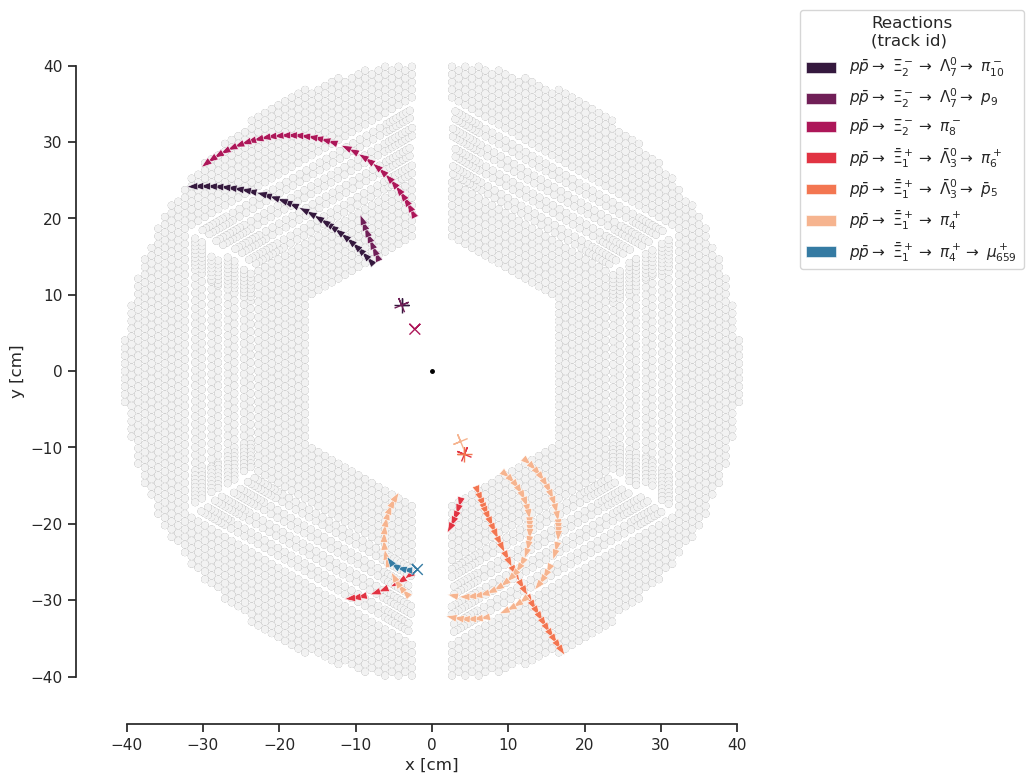

In [18]:
plt.close('all')

# Set the general style of the plot using seaborn
sns.set_theme(color_codes=True)
sns.set_style("ticks")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(8,8))

# Plot the IP
ax.plot(0,0,marker='.',ms=5, color='black')

# Plot the STT in the background
for index, row in data.iterrows():
        sttOuterTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['outerRadius[cm]'], fc='gray', ec="None")
        ax.add_patch(sttOuterTube)
        sttInnerTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['innerRadius[cm]'], fc='white', ec="None", alpha=0.9)
        ax.add_patch(sttInnerTube)

primaryColors   = sns.color_palette("rocket", nPrimaryTracks)
secondaryColors = sns.color_palette("mako"  , nSecondaryTracks)

primaryTrackNum   = 0
secondaryTrackNum = 0

for trackID in xPointsPerTrack:
	trackLabel = getProcess(trackID, mcTrack_pdgId, mcTrack_motherId, mcTrack_2ndMotherId)
	trackNormPx=xMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + yMomentaPerTrack[trackID]**2)
	trackNormPy=yMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + yMomentaPerTrack[trackID]**2)
	if isSttTrackPrimary[trackID]:
		create_rotated_cross(mcTrack_vertex_x[trackID], mcTrack_vertex_y[trackID], 22.5*primaryTrackNum+secondaryTrackNum, ax, size=1, color=primaryColors[primaryTrackNum], lw=1)
		ax.quiver(xPointsPerTrack[trackID], yPointsPerTrack[trackID], trackNormPx, trackNormPy, pivot='middle', angles='xy', scale_units='xy',
           		  lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001, units='xy', scale=0.7,
           	      color=primaryColors[primaryTrackNum], label=trackLabel)
		primaryTrackNum += 1
	else:
		create_rotated_cross(mcTrack_vertex_x[trackID], mcTrack_vertex_y[trackID], 22.5*primaryTrackNum+secondaryTrackNum, ax, size=1, color=secondaryColors[secondaryTrackNum], lw=1)
		ax.quiver(xPointsPerTrack[trackID], yPointsPerTrack[trackID], trackNormPx, trackNormPy, pivot='middle', angles='xy', scale_units='xy',
           		  lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001, units='xy', scale=0.7,
           	      color=secondaryColors[secondaryTrackNum], label=trackLabel)
		secondaryTrackNum += 1
	display(Latex(f"{trackLabel}: $x = {mcTrack_vertex_x[trackID]:.2f}$ cm  $y = {mcTrack_vertex_y[trackID]:.2f}$ cm"))

# Set the axis labels and limits
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Remove the top and right spines
sns.despine(fig=fig, ax=ax, offset=10, trim=True)

fig.tight_layout()	

fig.legend(title="Reactions\n(track id)", loc="upper left", bbox_to_anchor=(1, 1))

imgPath = imagePath + "/xyProjectionTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Detector Hits

Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionDetectorHits_0.png
Saving pdf image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionDetectorHits_0.pdf


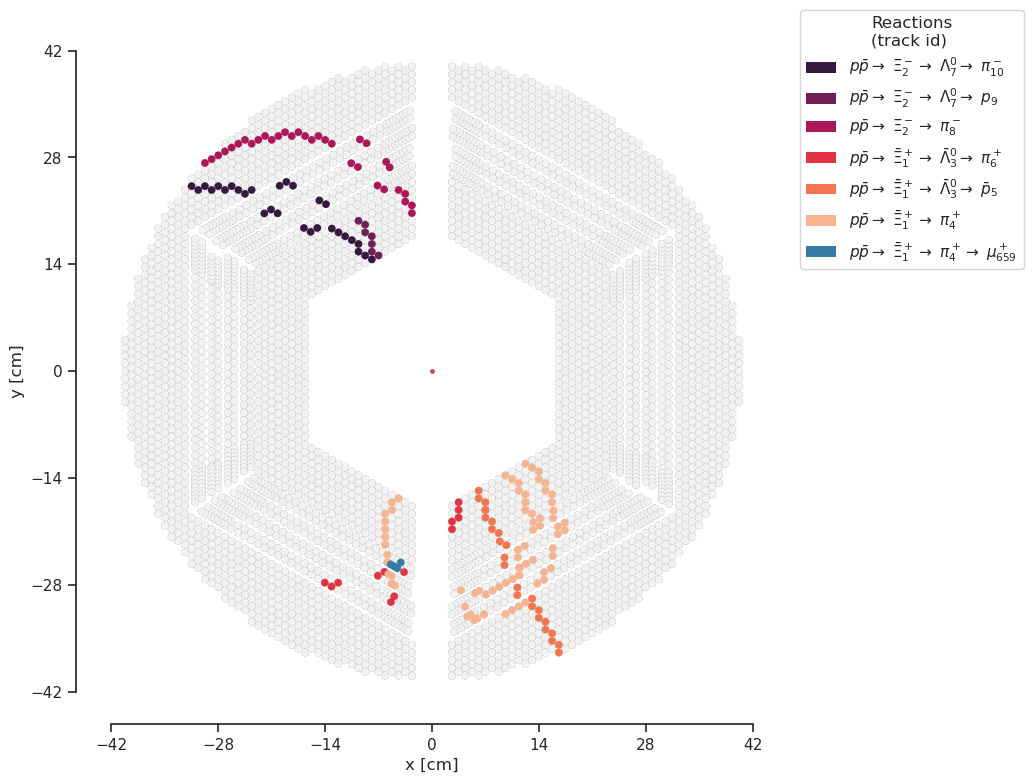

In [19]:
plt.close('all')

# Set the general style of the plot using seaborn
sns.set_theme(color_codes=True)
sns.set_style("ticks")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(8,8))

# Plot the IP
ax.plot(0,0,marker='.',ms=5, color='r')

# Plot the STT in the background
for index, row in data.iterrows():
        sttOuterTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['outerRadius[cm]'], fc='gray', ec="None")
        ax.add_patch(sttOuterTube)
        sttInnerTube = patches.Circle((row['x[cm]'], row['y[cm]']), row['innerRadius[cm]'], fc='white', ec="None", alpha=0.9)
        ax.add_patch(sttInnerTube)

primaryColors   = sns.color_palette("rocket", nPrimaryTracks)
secondaryColors = sns.color_palette("mako"  , nSecondaryTracks)

primaryTrackNum   = 0
secondaryTrackNum = 0

legendHandles = []
legendLabels = []

for trackID in tubeIDPerTrack:
	trackLabel = getProcess(trackID, mcTrack_pdgId, mcTrack_motherId, mcTrack_2ndMotherId)
	if isSttTrackPrimary[trackID]:
		for tube in tubeIDPerTrack[trackID]:
				sttHitTube = patches.Circle((data.loc[data["tubeID"] == tube, ['x[cm]']].iat[0,0], data.loc[data["tubeID"] == tube, ['y[cm]']].iat[0,0]),
											data.loc[data["tubeID"] == tube, ['outerRadius[cm]']].iat[0,0], fc=primaryColors[primaryTrackNum], ec="None")
				ax.add_patch(sttHitTube)
		primaryTrackNum += 1
	else:
		for tube in tubeIDPerTrack[trackID]:
			sttHitTube = patches.Circle((data.loc[data["tubeID"] == tube, ['x[cm]']].iat[0,0], data.loc[data["tubeID"] == tube, ['y[cm]']].iat[0,0]),
                              		     data.loc[data["tubeID"] == tube, ['outerRadius[cm]']].iat[0,0], fc=secondaryColors[secondaryTrackNum], ec="None")
			ax.add_patch(sttHitTube)
		secondaryTrackNum += 1
	legendHandles.append(sttHitTube)
	legendLabels.append(trackLabel)

# Set the axis labels and limits
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

# Set the ticks positions to match the data range
x_ticks = np.linspace(-42, 42, num=7)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Remove the top and right spines
sns.despine(fig=fig, ax=ax, offset=10, trim=True)

fig.tight_layout()	

fig.legend(legendHandles, legendLabels, title="Reactions\n(track id)",loc="upper left",ncols=1,bbox_to_anchor=(1,1))

imgPath = imagePath + "/xyProjectionDetectorHits_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

### Plot xz-Projections with Colormaps for various Parameters

In [20]:
# Normalize the momenta to the xz-projection
stt_normPx = stt_px/np.sqrt(stt_px**2 + stt_pz**2)
stt_normPz = stt_pz/np.sqrt(stt_px**2 + stt_pz**2)

mvd_normPx = mvd_px/np.sqrt(mvd_px**2 + mvd_pz**2)
mvd_normPz = mvd_pz/np.sqrt(mvd_px**2 + mvd_pz**2)


#### y-Position

Min y:  -36.60626983642578  cm
Max y:  30.882190704345703  cm
Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionDetectorHits_0.png
Saving pdf image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/xyProjectionDetectorHits_0.pdf


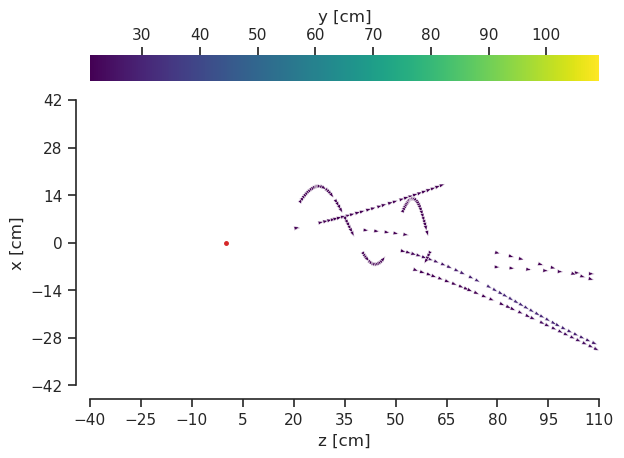

In [21]:
# find out what the maximum and minimum x values are
y_coords = np.concatenate((stt_y, mvd_y))
min_y = np.min(y_coords)
print("Min y: ", min_y, " cm")
max_y = np.max(y_coords)
print("Max y: ", max_y, " cm")

# Create a normalization object
yNorm = mcolors.Normalize(vmin=min_y, vmax=max_y)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the z coordinate
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_y, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=zNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_y, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=zNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="y [cm]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/xyProjectionDetectorHits_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Time

Saving png image to:  /home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/sim/XiAntiXi_xzProjectionTime_0.png


FileNotFoundError: [Errno 2] No such file or directory: '/home/nikin105/sciebo/Doktor/ML-Project/Images/pandaml/sim/XiAntiXi/sim/XiAntiXi_xzProjectionTime_0.png'

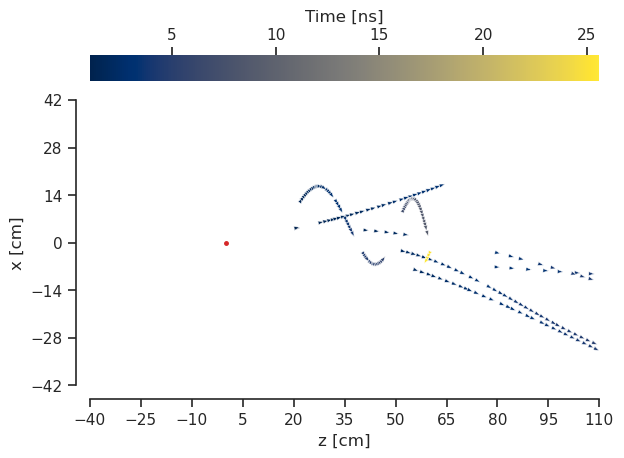

In [22]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the time
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Time [ns]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_xzProjectionTime_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Momentum

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Total Momentum [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_xzProjectionMomentum_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Energy Loss

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Energy Loss [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_xzProjectionEnergyLoss_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Tracks

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='black')

# Get the tab20 colormap
tab20 = plt.colormaps['tab20']
colorNum = 0

for trackID in xPointsPerTrack:
	if mcTrack_pdgId[trackID] == 13:
		trackLabel = r'$\mu^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -13:
		trackLabel = r'$\mu^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 11:
		trackLabel = r'$e^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -11:
		trackLabel = r'$e^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 211:
		trackLabel = r'$\pi^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -211:
		trackLabel = r'$\pi^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 2212:
		trackLabel = r'$p_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -2212:
		trackLabel = r'$\bar{p}_{'+ str(trackID) +r'}$'
	else:
		trackLabel: str = "PDG ID: " + str(mcTrack_pdgId[trackID])
	tab20color = tab20(colorNum % 20)
	trackNormPx=xMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	trackNormPz=zMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	ax.quiver(zPointsPerTrack[trackID], xPointsPerTrack[trackID], trackNormPz, trackNormPx, pivot='middle',
           angles='xy', scale_units='xy', units='xy', scale=0.6,lw=0.4, edgecolor='white', headwidth=3.5, 
           headlength=5, headaxislength=5, minlength=0.001 ,color=tab20color, label=trackLabel)
	colorNum += 1

# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

fig.tight_layout()	

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.legend(title="Particles (track id)",loc="upper center",ncols=len(xPointsPerTrack)/2,bbox_to_anchor=(0.5,1.3))

imgPath = imagePath + "/sim/" + projectName + "_xzTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

### Plot yz-Projections with Colormaps for various Parameters

In [ ]:
# Normalize the momenta to the xz-projection
stt_normPy = stt_py/np.sqrt(stt_py**2 + stt_pz**2)
stt_normPz = stt_pz/np.sqrt(stt_py**2 + stt_pz**2)

mvd_normPy = mvd_py/np.sqrt(mvd_py**2 + mvd_pz**2)
mvd_normPz = mvd_pz/np.sqrt(mvd_py**2 + mvd_pz**2)


#### x-Position

In [ ]:
# find out what the maximum and minimum x values are
x_coords = np.concatenate((stt_x, mvd_x))
min_x = np.min(x_coords)
print("Min x: ", min_x, " cm")
max_x = np.max(x_coords)
print("Max x: ", max_x, " cm")

# Create a normalization object
xNorm = mcolors.Normalize(vmin=min_x, vmax=max_x)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the z coordinate
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_x, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=xNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_x, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=xNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="x [cm]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjection_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Time

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the time
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Time [ns]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjectionTime_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Momentum

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Total Momentum [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjectionMomentum_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Energy Loss

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Energy Loss [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjectionEnergyLoss_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Tracks

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='black')

# Get the tab20 colormap
tab20 = plt.colormaps['tab20']
colorNum = 0

for trackID in xPointsPerTrack:
	if mcTrack_pdgId[trackID] == 13:
		trackLabel = r'$\mu^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -13:
		trackLabel = r'$\mu^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 11:
		trackLabel = r'$e^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -11:
		trackLabel = r'$e^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 211:
		trackLabel = r'$\pi^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -211:
		trackLabel = r'$\pi^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 2212:
		trackLabel = r'$p_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -2212:
		trackLabel = r'$\bar{p}_{'+ str(trackID) +r'}$'
	else:
		trackLabel: str = "PDG ID: " + str(mcTrack_pdgId[trackID])
	tab20color = tab20(colorNum % 20)
	trackNormPy=yMomentaPerTrack[trackID]/np.sqrt(yMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	trackNormPz=zMomentaPerTrack[trackID]/np.sqrt(yMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	ax.quiver(zPointsPerTrack[trackID], yPointsPerTrack[trackID], trackNormPz, trackNormPy, pivot='middle',
           angles='xy', scale_units='xy', units='xy', scale=0.6,lw=0.4, edgecolor='white', headwidth=3.5, 
           headlength=5, headaxislength=5, minlength=0.001 ,color=tab20color, label=trackLabel)
	colorNum += 1

# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

fig.tight_layout()	

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.legend(title="Particles (track id)",loc="upper center",ncols=len(xPointsPerTrack)/2,bbox_to_anchor=(0.5,1.3))

imgPath = imagePath + "/sim/" + projectName + "_yzTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

### 3D Scatter Plot

In [ ]:
# Normalize the momenta
stt_normPx = stt_px / np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)
stt_normPy = stt_py / np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)
stt_normPz = stt_pz / np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)

mvd_normPx = mvd_px / np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)
mvd_normPy = mvd_py / np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)
mvd_normPz = mvd_pz / np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# Plot the IP
scatter=ax.scatter(0,0,0,marker='.', color='black')

# Set the axis labels and limits
xCoords = np.concatenate((stt_x, mvd_x))
yCoords = np.concatenate((stt_y, mvd_y))
zCoords = np.concatenate((stt_z, mvd_z))

min_x = np.min(xCoords)
max_x = np.max(xCoords)
min_y = np.min(yCoords)
max_y = np.max(yCoords)
min_z = np.min(zCoords)
max_z = np.max(zCoords)

plt.xlabel("z [cm]")
plt.xlim(min_z, max_z)
plt.ylabel("x [cm]")
plt.ylim(min_x, max_x)
ax.set_zlabel("y [cm]")
ax.set_zlim(min_y, max_y)

# Get the tab20 colormap
tab20 = plt.colormaps['tab20']
colorNum = 0

for trackID in yPointsPerTrack:
	if mcTrack_pdgId[trackID] == 13:
		trackLabel = r'$\mu^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -13:
		trackLabel = r'$\mu^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 11:
		trackLabel = r'$e^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -11:
		trackLabel = r'$e^{+}_{'+ str(trackID) +r'}$'
	else:
		trackLabel = "PDG ID: " + str(mcTrack_pdgId[trackID])
	tab20color = tab20(colorNum % 20)
	trackAbsMom = np.sqrt(xMomentaPerTrack[trackID]**2 + yMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	trackNormPx=xMomentaPerTrack[trackID]/trackAbsMom
	trackNormPy=yMomentaPerTrack[trackID]/trackAbsMom
	trackNormPz=zMomentaPerTrack[trackID]/trackAbsMom
	ax.quiver(zPointsPerTrack[trackID], yPointsPerTrack[trackID], xPointsPerTrack[trackID], trackNormPz,
			trackNormPy, trackNormPx, pivot='middle' ,color=tab20color, label=trackLabel, length=1,
   			normalize=True, arrow_length_ratio=2, lw=0.6)
	colorNum += 1


# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

fig.tight_layout()	

plt.legend(title="Particles\n(track id)", loc="upper left",ncol=1,bbox_to_anchor=(-0.2,0.85))

imgPath = imagePath + "/sim/" + projectName + "_3dTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')